***
# Solution: Static Feature Extraction
***




*By Asmik Nalmpatian and Lisa Wimmer – for Intro to NLP*

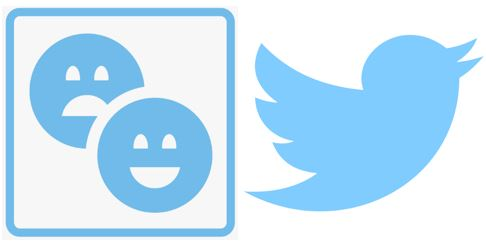

## Set-up

Check: `Runtime type = R`?

➡ If not, re-launch Google Colab via https://colab.to/r and upload this notebook there.



### Packages

In [ ]:
# Install all required packages

install.packages("data.table")
install.packages("quanteda")
install.packages("SnowballC")
install.packages("stringr")

In [ ]:
# Load all required packages

library(data.table)
library(quanteda)
library(SnowballC)
library(stringr)

### Data

1. On the left command pane, move to the `Files` section.
2. Select 'Upload to the session storage'.
3. Upload the `twitter_corpus.RDS` and `twitter_dfm.RDS` data from the course website (the data will vanish as soon as you terminate the colab session).

### Helper function for cleaning & stemming

This is the function we created in the demo:

In [3]:
clean_and_stem <- function(text) {
  
  # Convert to uniform encoding
  text <-  stringi::stri_trans_general(text, "Any-Latin")
  
  # Replace umlauts and litigate s
  text <- stringr::str_replace_all(
    text,
      c("\u00c4" = "Ae",
      "\u00e4" = "ae",
      "\u00d6" = "Oe",
      "\u00f6" = "oe",
      "\u00dc" = "Ue",
      "\u00fc" = "ue",
      "\u00df" = "ss"))
  
  # Stem
  text <- SnowballC::wordStem(text)
  
  text

}

In [5]:
twitter_corpus <- readRDS("twitter_corpus.RDS")
twitter_dfm <- readRDS("twitter_dfm.RDS")

## Exercise 1: Find Polarity Clues

#### Task

Rather than classic positive/negative polarity, look for tokens indicating a relation to governmental issues. 

Hints:

1. Create a `dictionary` containing indicative terms (e.g., something like "Demokratie", "Bundesregierung", "Parlament").
  1. We don't need an extensive list, this is just an exercise :)
  2. If required, the helper function used in the demo is provided above.
  3. With `quanteda::featnames()` you can query the features included in `twitter_dfm` (narrow down the hits using 
`quanteda::featnames(twitter_dfm)[startsWith(quanteda::featnames(twitter_dfm), "bundes")]` or directly check whether `"demokratie" %in% quanteda::featnames(twitter_dfm)`.
2. Use `twitter_dfm.RDS` to perform the look-up.
3. How many documents of `twitter_dfm` contain a match? (Hint: printing a `dfm` object contains this info.) 


*Solution*

In [ ]:
# Find government-related terms occurring in twitter_dfm

# 1. Direct query (making the cleaning part obsolete)

terms_bundes <- quanteda::featnames(twitter_dfm)[
  startsWith(quanteda::featnames(twitter_dfm), "bundes")]
terms_regierung <- quanteda::featnames(twitter_dfm)[
  startsWith(quanteda::featnames(twitter_dfm), "regier")]

# 2. Own ideas (don't forget to clean)

terms_misc <- clean_and_stem(c("demokratie", "minister", "kanzlerin"))

# 3. Collect

terms_government <- sort(unique(c(terms_bundes, terms_regierung, terms_misc)))
terms_government

In [ ]:
# Create dictionary

dictionary_government <- quanteda::dictionary(
  list(government = terms_government))
dictionary_government

In [ ]:
# Perform look-up

twitter_government <- quanteda::dfm_lookup(twitter_dfm, dictionary_government)
twitter_government

In [ ]:
# Count matches

sparsity <- quanteda::sparsity(twitter_government)

documents_with_matches <- 1 - sparsity
documents_with_matches

## Exercise 2: Count Hashtags

#### Task

In the demo, we counted the number of emojis used in each tweets.
You will now do the same for hashtags.

Afterwards, check how many tweets use 0, 1, ... hashtags. What is the highest number of hashtags used in a single document?

Hints:

1. For this, you need to access the corpus' `docvars`.
2. As for the emojis, the hashtags are stored in lists.

In [ ]:
# Get docvars

twitter_docvars <- data.table::as.data.table(
  cbind(
    doc_id = quanteda::docid(twitter_corpus),
    quanteda::docvars(twitter_corpus)), 
  key = "doc_id")

head(twitter_docvars)

In [11]:
# Get number of hashtags

twitter_hashtags <- twitter_docvars[
  , .(doc_id, hashtags)
  ][, n_hashtags := lengths(hashtags)
    ][, hashtags := NULL]

In [ ]:
# Table hashtag use

table(twitter_hashtags$n_hashtags) # max 13 hashtags

## Exercise 3: Find Intensifiers

#### Task

Building on the hypothesis that intensifiers are indicative of (strong) sentiment, find and count for each tweet the number of intensifying words (e.g., "sehr").

Hints:

1. Don't forget to clean and stem.
2. You can do the counting part using, again, a `dictionary`.

In [13]:
# Define intensifiers

tokens_intensification <- clean_and_stem(c(
    "sehr", 
    "total", 
    "absolut", 
    "besonders", 
    "wahnsinnig", 
    "enorm",
    "sogar",
    "viel",
    "völlig",
    "vollkommen")) # ... and anything else you come up with

In [15]:
# Create dictionary

dictionary_intensification <- quanteda::dictionary(
  list(intensification = tokens_intensification))

In [ ]:
# Perform look-up

twitter_intensification <- quanteda::dfm_lookup(
  twitter_dfm, 
  dictionary_intensification)

twitter_intensification

## Exercise 4: Collect Features

#### Task

We have created various objects on the way (most are of class `dfm`).

As a final step, convert all of them to a standard tabular format (e.g., a `data.table` or a `data.frame`) and put them together in a single object.


In [ ]:
# 1. Via data.frame

# If you need to install tidyverse, replace FALSE by TRUE

if (FALSE) {
  install.packages("tidyverse")
  library(tidyverse)
}

# Convert everything to data.frame

twitter_government_df <- quanteda::convert(
  twitter_government, 
  to = "data.frame")
twitter_hashtags_df <- as.data.frame(twitter_hashtags)
twitter_intensification_df <- quanteda::convert(
  twitter_intensification, 
  to = "data.frame")

# Join

twitter_features_df <- dplyr::left_join(
  data.frame(doc_id = twitter_docvars$doc_id), 
  twitter_government_df,
  by = "doc_id")

twitter_features_df <- dplyr::left_join(
  twitter_features_df,
  twitter_hashtags_df,
  by = "doc_id")

twitter_features_df <- dplyr::left_join(
  twitter_features_df,
  twitter_intensification_df,
  by = "doc_id")

# Inspect

head(twitter_features_df)

In [ ]:
# 2. Via data.table

# Convert everything to data.table

twitter_government_dt <- data.table::as.data.table(
  quanteda::convert(
    twitter_government,
    to = "data.frame"),
  key = "doc_id")

twitter_intensification_dt <- data.table::as.data.table(
  quanteda::convert(
    twitter_intensification,
    to = "data.frame"),
  key = "doc_id")

# Join

twitter_features_dt <- twitter_docvars[, .(doc_id)
  ][twitter_government_dt,
    ][twitter_hashtags, # data.table already
      ][twitter_intensification_dt, ]

# Inspect

head(twitter_features_dt)